## Import package

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data Import

In [ ]:
df_train=pd.read_csv("../original_data/mitbih_train.csv")
df_test=pd.read_csv("../original_data/mitbih_test.csv")

In [134]:
df_train.columns = np.arange(188)
df_test.columns = np.arange(188)

In [135]:
X_train=df_train.iloc[:,:-1]
y_train=df_train.iloc[:,-1]
X_test=df_test.iloc[:,:-1]
y_test=df_test.iloc[:,-1]

In [136]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=13
)

## Resampling

In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from tqdm import tqdm

# ---------------------
# Step 1: GAN Definitions
# ---------------------

class Generator(nn.Module):
    def __init__(self, latent_dim=100, signal_length=187):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, signal_length),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.model(z)
        return x.unsqueeze(1)  # shape: (B, 1, 187)

class Discriminator(nn.Module):
    def __init__(self, signal_length=187):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(signal_length, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ---------------------
# Step 2: Train a GAN for one class
# ---------------------

def train_gan_for_class(X_class, epochs=1000, batch_size=64, latent_dim=100, device='cuda'):
    G = Generator(latent_dim).to(device)
    D = Discriminator().to(device)

    opt_G = optim.Adam(G.parameters(), lr=1e-4)
    opt_D = optim.Adam(D.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    X_tensor = torch.tensor(X_class.values, dtype=torch.float32).unsqueeze(1).to(device)

    for epoch in range(epochs):
        idx = torch.randint(0, len(X_tensor), (batch_size,))
        real = X_tensor[idx]

        z = torch.randn(batch_size, latent_dim).to(device)
        fake = G(z)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        D_real = D(real)
        D_fake = D(fake.detach())
        D_loss = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)

        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()

        # Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake = G(z)
        D_fake = D(fake)
        G_loss = loss_fn(D_fake, real_labels)

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}")

    return G

# ---------------------
# Step 3: Generate synthetic samples
# ---------------------

def generate_samples(generator, num_samples, latent_dim=100, device='cuda'):
    generator.eval()
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        gen_samples = generator(z).cpu().squeeze(1).numpy()
    return gen_samples

# ---------------------
# Step 4: Loop for each class and augment
# ---------------------

def augment_with_gan(X_train, y_train, target_classes=[1,2,3,4], target_size=15000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    latent_dim = 100
    all_generated = []
    all_labels = []

    for cls in target_classes:
        print(f"\nTraining GAN for Class {cls}")
        X_cls = X_train[y_train == cls]
        G = train_gan_for_class(X_cls, device=device)
        X_gen = generate_samples(G, target_size, latent_dim=latent_dim, device=device)
        all_generated.append(pd.DataFrame(X_gen))
        all_labels.extend([cls] * target_size)

    X_generated_df = pd.concat(all_generated, ignore_index=True)
    y_generated_df = pd.Series(all_labels)

    # Combine with original training data
    X_aug = pd.concat([X_train, X_generated_df], ignore_index=True)
    y_aug = pd.concat([y_train, y_generated_df], ignore_index=True)

    return X_aug, y_aug

In [138]:

X_train_gan, y_train_gan = augment_with_gan(X_train, y_train)


Training GAN for Class 1
[Epoch 0] D_loss: 1.3981, G_loss: 0.6471
[Epoch 100] D_loss: 1.3755, G_loss: 0.6164
[Epoch 200] D_loss: 1.2879, G_loss: 0.7466
[Epoch 300] D_loss: 1.3942, G_loss: 0.6972
[Epoch 400] D_loss: 1.2192, G_loss: 0.7105
[Epoch 500] D_loss: 1.4429, G_loss: 0.7620
[Epoch 600] D_loss: 1.2877, G_loss: 0.7195
[Epoch 700] D_loss: 1.3696, G_loss: 0.7170
[Epoch 800] D_loss: 1.3439, G_loss: 0.7530
[Epoch 900] D_loss: 1.3539, G_loss: 0.7057

Training GAN for Class 2
[Epoch 0] D_loss: 1.4105, G_loss: 0.7256
[Epoch 100] D_loss: 1.3707, G_loss: 0.6474
[Epoch 200] D_loss: 1.2944, G_loss: 0.8460
[Epoch 300] D_loss: 1.3451, G_loss: 0.7367
[Epoch 400] D_loss: 1.2503, G_loss: 0.8439
[Epoch 500] D_loss: 1.3502, G_loss: 0.7336
[Epoch 600] D_loss: 1.4112, G_loss: 0.7154
[Epoch 700] D_loss: 1.2751, G_loss: 0.7738
[Epoch 800] D_loss: 1.3508, G_loss: 0.7152
[Epoch 900] D_loss: 1.3921, G_loss: 0.6818

Training GAN for Class 3
[Epoch 0] D_loss: 1.3832, G_loss: 0.6682
[Epoch 100] D_loss: 1.395

In [139]:
print(y_train_gan.value_counts())

0.0    54352
4.0    19823
2.0    19341
1.0    16667
3.0    15481
Name: count, dtype: int64


In [140]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under_sampler = RandomUnderSampler(sampling_strategy={0: 15000,
                                                      1: 15000, 
                                                      2: 15000, 
                                                      3: 15000, 
                                                      4: 15000, 
                                                      }, random_state=13) 
# over_sampler = SMOTETomek(sampling_strategy={1: 15000, 
#                                         2: 15000, 
#                                         3: 15000, 
#                                         4: 15000},random_state=13)

pipeline = Pipeline([
    ('under', under_sampler), 
    # ('over', over_sampler)   
])

X_resampled, y_resampled = pipeline.fit_resample(X_train_gan, y_train_gan)


In [141]:
print(y_resampled.value_counts())

0.0    15000
1.0    15000
2.0    15000
3.0    15000
4.0    15000
Name: count, dtype: int64


In [142]:
label_map = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

class_counts = y_train.value_counts().sort_index()

class_labels = [label_map[i] for i in class_counts.index]

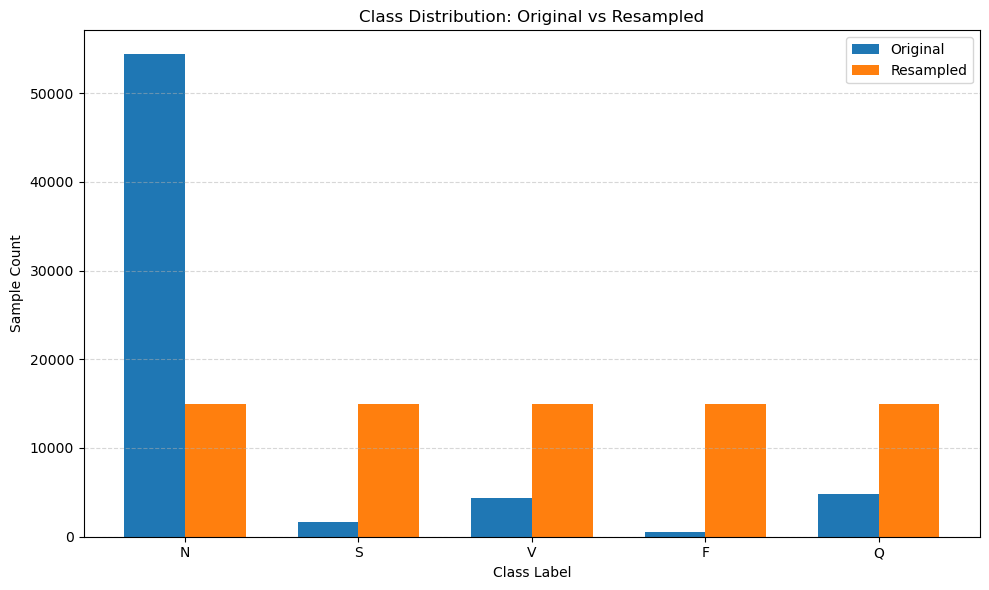

In [143]:
original_counts = y_train.value_counts().sort_index()
resampled_counts = pd.Series(y_resampled).value_counts().sort_index()

classes = original_counts.index.tolist()
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_counts.values, width=width, label="Original")
plt.bar(x + width/2, resampled_counts.values, width=width, label="Resampled")

plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.title("Class Distribution: Original vs Resampled")
plt.xticks(x, class_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## CNN

In [144]:
# import torch and relative functions

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [145]:
# Modify data and data loader


# convert to Tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Construct dataset and loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [146]:
print(X_train_tensor.shape)
print(X_val_tensor.shape)
print(X_test_tensor.shape)

torch.Size([65664, 1, 187])
torch.Size([21889, 1, 187])
torch.Size([21891, 1, 187])


In [156]:
#define plot structure
def plot_losses(train_losses, test_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validating Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [190]:
class CNN_v1(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(2)
        
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu((self.conv1(x))))
        x = self.pool2(F.relu((self.conv2(x))))
        x = self.pool3(F.relu((self.conv3(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [198]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [210]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, downsample=False):
        super().__init__()
        padding = kernel_size // 2
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        return self.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 64, num_blocks=2, downsample=False)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, downsample=True)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, downsample=True)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, downsample=True)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, downsample):
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, downsample=downsample))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

In [229]:
# parameters of model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet1D().to(device)
num_epochs = 100
learning_rate= 1e-4
weight_decay=1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses = []
val_losses = []

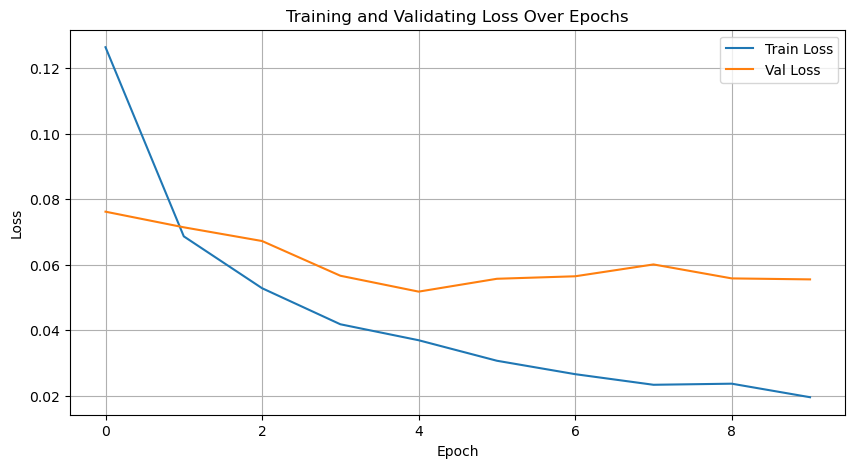

In [230]:
best_val_loss = float('inf')
patience = 5              # stop when there are 5 steps no imporvement
min_delta = 1e-4          # define imporvement is greater than 1e-4
counter = 0               
best_model_state = None   # save the best_model_state

# training
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")
    
    plot_losses(train_losses, val_losses)

    # Early stopping check
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break

# Restore best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)

In [233]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(batch_y.numpy())


print(model)
print(classification_report(y_true, y_pred, digits=3))

ResNet1D(
  (initial): Sequential(
    (0): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplac

In [234]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(batch_y.numpy())


print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.991     0.991     0.991     18117
           1      0.812     0.829     0.820       556
           2      0.974     0.934     0.953      1448
           3      0.693     0.852     0.765       162
           4      0.988     0.987     0.987      1608

    accuracy                          0.982     21891
   macro avg      0.892     0.919     0.903     21891
weighted avg      0.983     0.982     0.982     21891



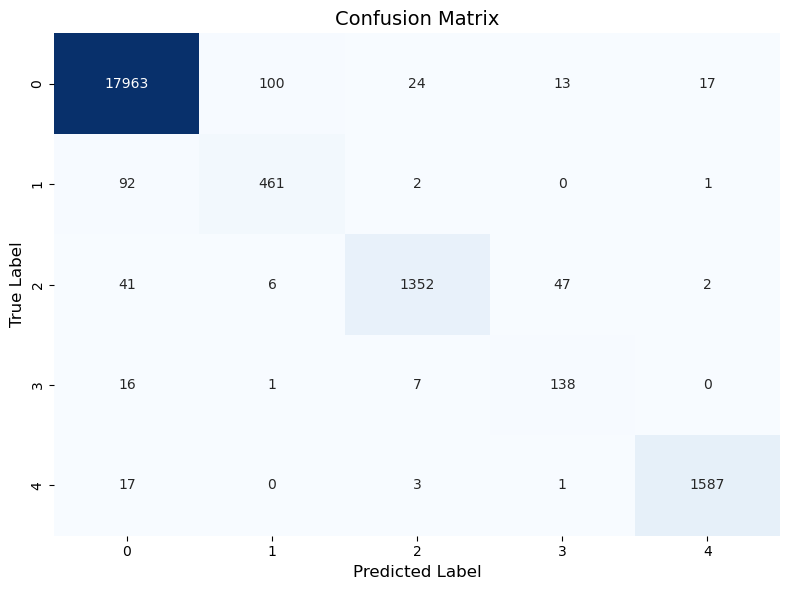

In [235]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [236]:
torch.save(model.state_dict(), 'cnn_model.pkl')